# Without Technical Indicators And Sentiment In The State Notebook

In this particular notebook, we just added price and price difference into the state representation, enabling the agent to choose the best action based on the price and price difference. Additionally, we used 14 as the window size and then split the dataset into two groups: training and testing. We trained the agent for 250,000 timesteps, equivalent to 117 episodes. At the end, we evaluated the agent's performance based on the average total reward and average total profit gained after a 10-episode evaluation on unseen data (testing data).

## Price And Price Difference In The State

### Pip Install Commands

In [101]:
!pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

### Libraries

In [102]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3 import PPO



from gym_anytrading.envs import StocksEnv
from finta import TA






### Const Values

In [103]:
WINDOW_SIZE = 14
DATASET_PATH = '/content/TSLA.csv'

### Code

Read the dataset and preprocess it

In [104]:
df = pd.read_csv(DATASET_PATH)

Change the type of Date column to datetime

In [105]:
df['Date'] = pd.to_datetime(df.Date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


Make the Date column an index

In [107]:
df.set_index('Date', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sort it by index

In [108]:
df.sort_index(inplace=True)

In [109]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Split the dataset

In [111]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  2142
test_df:  814


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
train_df.shape

(2142, 6)

Create an environment and provide training data

In [113]:
env = gym.make('stocks-v0', df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

A single vector representing the state.

In [114]:
env.signal_features[:1,:]

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[4.778, 0.   ]], dtype=float32)

In [115]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [116]:
env.action_space.sample()

0

Sell = 0

Buy = 1

In [117]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (14, 2), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [118]:
env.observation_space.sample()

array([[ 9.4092524e+09, -9.9261952e+09],
       [ 4.7140403e+09,  8.6062899e+09],
       [-2.9990610e+09, -1.2783187e+09],
       [ 3.8030543e+09, -5.8963820e+09],
       [-4.0251715e+09,  9.5311421e+09],
       [-7.2921846e+09, -7.0951060e+09],
       [ 7.9947351e+09,  3.6701693e+09],
       [-6.7865631e+09,  9.9433357e+08],
       [-7.5978383e+09, -3.7983247e+09],
       [-5.4260408e+09,  3.9934595e+09],
       [-3.4493783e+09, -3.6103954e+09],
       [ 6.9712256e+09,  9.0926428e+09],
       [-3.8677079e+09,  3.6607178e+09],
       [-5.1800556e+09,  3.3338509e+09]], dtype=float32)

Create the environment and do some random action on it

info: {'total_reward': 45.9839825630188, 'total_profit': 0.004284677626299343, 'position': <Positions.Short: 0>}


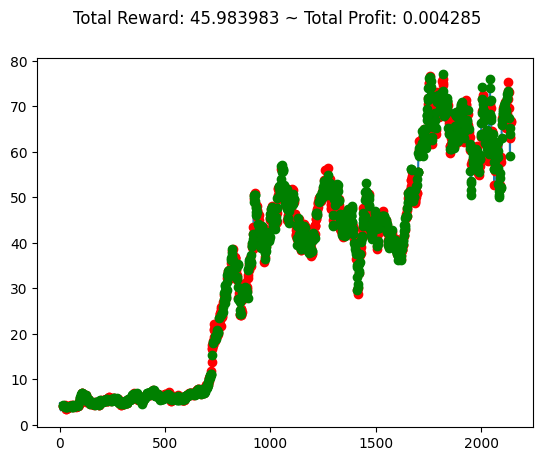

In [119]:

observation = env.reset(seed=2024)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

Create and training the A2C model on 250000 timesteps

In [120]:
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=250000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13e+03 |
|    ep_rew_mean      | 23.4     |
|    exploration_rate | 0.919    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1602     |
|    time_elapsed     | 5        |
|    total_timesteps  | 8508     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.07     |
|    n_updates        | 2101     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13e+03 |
|    ep_rew_mean      | 33.2     |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1618     |
|    time_elapsed     | 10       |
|    total_timesteps  | 17016    |
| train/              |        

Save model

In [121]:
# model.save('ppo_1000000_15_senti')

In [122]:
# del model

Load model

In [123]:
# model = A2C.load('/content/ppo_1000000_15_senti.zip')

Evaluate the model using new environment which will have the testing data, for 10 episodes.

In [124]:
env = gym.make('stocks-v0', df=test_df, frame_bound=(WINDOW_SIZE, len(test_df)), window_size=WINDOW_SIZE)

avg_reward = []
avg_profit = []

for i in range(10):
  observation, info = env.reset(seed=2024)
  while True:
      # print('ob',observation)
      action = model.predict(observation)
      # print('action',action[0])
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      # env.render()
      if done:
          print("info:", info)
          avg_reward.append(info['total_reward'])
          avg_profit.append(info['total_profit'])
          break

  # plt.cla()
  # env.unwrapped.render_all()
  # plt.show()
print('\nAverage reward: ', np.mean(avg_reward))
print('\nAverage profit: ', np.mean(avg_profit))

info: {'total_reward': 338.7319107055664, 'total_profit': 0.1868569798715606, 'position': <Positions.Long: 1>}
info: {'total_reward': 464.6120262145996, 'total_profit': 0.18728088020862665, 'position': <Positions.Long: 1>}
info: {'total_reward': 582.8038940429688, 'total_profit': 0.26416948339247515, 'position': <Positions.Long: 1>}
info: {'total_reward': 583.275821685791, 'total_profit': 0.2688464204223622, 'position': <Positions.Long: 1>}
info: {'total_reward': 471.09798431396484, 'total_profit': 0.2370447107167638, 'position': <Positions.Long: 1>}
info: {'total_reward': 656.5599136352539, 'total_profit': 0.2891006296453612, 'position': <Positions.Long: 1>}
info: {'total_reward': 655.037841796875, 'total_profit': 0.2777565058013174, 'position': <Positions.Long: 1>}
info: {'total_reward': 395.7379570007324, 'total_profit': 0.17288470463920386, 'position': <Positions.Long: 1>}
info: {'total_reward': 642.9957656860352, 'total_profit': 0.28065103490626614, 'position': <Positions.Long: 1>